In [1]:
import pennylane as qml
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pandas as pd
import argparse
import os
import math
import datetime
import time
from frechetdist import frdist

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch

from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn
from utils import *
from models import Generator, Discriminator
from data.sparse_molecular_dataset import SparseMolecularDataset
from rdkit import Chem

def str2bool(v):
    return v.lower() in ('true')

/home/junde/miniconda3/envs/kongsr-rdkit/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/junde/miniconda3/envs/kongsr-rdkit/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/junde/miniconda3/envs/kongsr-rdkit/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/junde/miniconda3/envs/

In [2]:
parser = argparse.ArgumentParser()

# Model configuration.
parser.add_argument('--z_dim', type=int, default=8, help='dimension of domain labels')
parser.add_argument('--g_conv_dim', default=[128], help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=[[128, 64], 128, [128, 64]], help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
parser.add_argument('--post_method', type=str, default='softmax', choices=['softmax', 'soft_gumbel', 'hard_gumbel'])

# Training configuration.
parser.add_argument('--batch_size', type=int, default=128, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=20000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=2000, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--dropout', type=float, default=0., help='dropout rate')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')

# Test configuration.
parser.add_argument('--test_iters', type=int, default=10000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=False)

# Directories.
parser.add_argument('--mol_data_dir', type=str, default='data/gdb9_9nodes.sparsedataset')
parser.add_argument('--log_dir', type=str, default='molgan/logs')
parser.add_argument('--model_save_dir', type=str, default='molgan/models')
parser.add_argument('--sample_dir', type=str, default='molgan/samples')
parser.add_argument('--result_dir', type=str, default='molgan/results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=1000)
parser.add_argument('--lr_update_step', type=int, default=1000)

config = parser.parse_known_args()[0]
print(config)

# For fast training.
cudnn.benchmark = True

Namespace(batch_size=128, beta1=0.5, beta2=0.999, d_conv_dim=[[128, 64], 128, [128, 64]], d_lr=0.0001, d_repeat_num=6, dropout=0.0, g_conv_dim=[128], g_lr=0.0001, g_repeat_num=6, lambda_cls=1, lambda_gp=10, lambda_rec=10, log_dir='molgan/logs', log_step=10, lr_update_step=1000, mode='train', model_save_dir='molgan/models', model_save_step=1000, mol_data_dir='data/gdb9_9nodes.sparsedataset', n_critic=5, num_iters=20000, num_iters_decay=2000, num_workers=1, post_method='softmax', result_dir='molgan/results', resume_iters=None, sample_dir='molgan/samples', sample_step=1000, test_iters=10000, use_tensorboard=False, z_dim=8)


In [3]:
dev = qml.device('default.qubit', wires=4)
@qml.qnode(dev, interface='torch')
def gen_circuit_1(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1
    qubits = 4
    
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
            print(i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            print(i+qubits)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

@qml.qnode(dev, interface='torch')
def gen_circuit_2(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1
    qubits = 4
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i+7], wires=i)
            print(i+7)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits+7], wires=i+1)
            print(i+qubits+7)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [99]:
w = torch.tensor(list(np.random.rand(14)*2-1), requires_grad=True)
torch.cat([gen_circuit_1(w), gen_circuit_2(w)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13


tensor([0.6741, 0.8815, 0.2990, 0.2667, 0.5196, 0.9200, 0.9105, 0.9229],
       dtype=torch.float64, grad_fn=<CatBackward>)

In [123]:
sample_list = [torch.cat([gen_circuit_1(w), gen_circuit_2(w)]) for i in range(7)]
z = torch.stack(tuple(sample_list)).to('cpu').float()

0
1
2
3
4
5
6
7
8
9
10
11


IndexError: index 12 is out of bounds for axis 0 with size 12

In [116]:
dev = qml.device('default.qubit', wires=2)
@qml.qnode(dev, interface='torch')
def gen_circuit_1(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1
    qubits = 2
    
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

@qml.qnode(dev, interface='torch')
def gen_circuit_2(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1
    qubits = 2
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i+3], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits+3], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

@qml.qnode(dev, interface='torch')
def gen_circuit_3(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1
    qubits = 2
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i+3*2], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits+3*2], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

@qml.qnode(dev, interface='torch')
def gen_circuit_4(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 1
    qubits = 2
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i+3*3], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits+3*3], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [117]:
w = torch.tensor(list(np.random.rand(12)*2-1), requires_grad=True)
[torch.cat([gen_circuit_1(w), gen_circuit_2(w), gen_circuit_3(w), gen_circuit_4(w)]) for i in range(3)]

[tensor([0.2500, 0.5290, 0.5061, 0.7878, 0.5537, 0.4524, 0.9821, 0.8538],
        dtype=torch.float64, grad_fn=<CatBackward>),
 tensor([0.2800, 0.5252, 0.8731, 0.1593, 0.9440, 0.9763, 0.8372, 0.9997],
        dtype=torch.float64, grad_fn=<CatBackward>),
 tensor([0.9743, 0.8851, 0.2375, 0.9552, 0.6988, 0.6503, 0.8191, 0.9968],
        dtype=torch.float64, grad_fn=<CatBackward>)]

In [4]:
dev = qml.device('default.qubit', wires=8)
@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    layers = 2
    qubits = 8
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i+15*l], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits+15*l], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [5]:
w = torch.tensor(list(np.random.rand(30)*2-1), requires_grad=True)
torch.cat([gen_circuit_1(w), gen_circuit_2(w), gen_circuit_3(w), gen_circuit_4(w)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13


NameError: name 'gen_circuit_3' is not defined

In [6]:
self = Solver(config)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=True)
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropoout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 59202
Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tanh_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Tanh()
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=128, out_feature

In [128]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [131]:
m0

{'NP score': 0.900098276214917,
 'QED score': 0.45752609736227534,
 'logP score': 0.2837258677101192,
 'SA score': 0.2976284457836144,
 'diversity score': 0.737572618801331,
 'drugcandidate score': 0.3451985005801226,
 'valid score': 100.0,
 'unique score': 100.0,
 'novel score': 0.0}

In [7]:
loss = {}
log = ''
qed = []
logp = []
sa = []

#FD Score experiments
for i in range(0, 1):
    mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)
#     try:
#         R2_ab = R1_ab
#         R2_b = R1_b
#     except:
#         R2_ab = [list(x[i]) + list(a[i].reshape(-1))  for i in range(self.batch_size)]
#         R2_b = [list(a[i].reshape(-1))  for i in range(self.batch_size)]
#     R1_ab = [list(x[i]) + list(a[i].reshape(-1))  for i in range(self.batch_size)]
#     R1_b = [list(a[i].reshape(-1))  for i in range(self.batch_size)]
    
#     fd_ab.append(frdist(R1_ab, R2_ab))
#     fd_b.append(frdist(R1_b, R2_b))
    
    m0, m1 = all_scores(mols, self.data, norm=True)     # 'mols' is output of Fake Reward
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    loss.update(m0)
    for tag, value in loss.items():
        if tag == 'QED score':
            qed.append(round(value, 4))
        if tag == 'logP score':
            logp.append(round(value, 4))
        if tag == 'SA score':
            sa.append(round(value, 4))
        
    log += ", {}: {:.4f}".format(tag, value)
    print(log)
    log = ''
    print()

, novel score: 0.0000



In [17]:
# Learning rate cache for decaying.
g_lr = self.g_lr
d_lr = self.d_lr
gen_weights = torch.tensor([0.44093025,-0.3495443,-0.17103225,-0.62883323,-0.89205253,0.25990093,-0.539537,0.72252595,0.89228415,\
                            0.04769561,-0.0035566252,0.7793881,-0.95167345,0.29773384,0.018899115], requires_grad=True) #16923
self.g_optimizer = torch.optim.Adam(list(self.G.parameters())+[gen_weights],
                                    self.g_lr, [self.beta1, self.beta2])
self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2]) #+[gen_weights]

# Start training from scratch or resume training.
start_iters = 0
self.resume_iters = 0
if self.resume_iters:
    start_iters = self.resume_iters
    self.restore_model(self.resume_iters)
    
# Start training.
print('Start training...')

for i in range(start_iters, self.num_iters):
    start_time = time.time()
    mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)
    real_mols = mols

    # =================================================================================== #
    #                             1. Preprocess input data                                #
    # =================================================================================== #

    a = torch.from_numpy(a).to(self.device).long()            # Adjacency.
    x = torch.from_numpy(x).to(self.device).long()            # Nodes.
    a_tensor = self.label2onehot(a, self.b_dim)
    x_tensor = self.label2onehot(x, self.m_dim)
    sample_list = [gen_circuit(gen_weights) for i in range(self.batch_size)]
    z = torch.stack(tuple(sample_list)).to(self.device).float()
#         z = self.sample_z(self.batch_size)
#         z = torch.from_numpy(z).to(self.device).float()

    # =================================================================================== #
    #                             2. Train the discriminator                              #
    # =================================================================================== #

    # Compute loss with real images.
    logits_real, features_real = self.D(a_tensor, None, x_tensor)
    d_loss_real = - torch.mean(logits_real)

    # Compute loss with fake images.
    edges_logits, nodes_logits = self.G(z)
    # Postprocess with Gumbel softmax
    (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
    logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
    d_loss_fake = torch.mean(logits_fake)

    # Compute loss for gradient penalty.
    eps = torch.rand(logits_real.size(0),1,1,1).to(self.device)
    x_int0 = (eps * a_tensor + (1. - eps) * edges_hat).requires_grad_(True)
    x_int1 = (eps.squeeze(-1) * x_tensor + (1. - eps.squeeze(-1)) * nodes_hat).requires_grad_(True)
    grad0, grad1 = self.D(x_int0, None, x_int1)
    d_loss_gp = self.gradient_penalty(grad0, x_int0) + self.gradient_penalty(grad1, x_int1)


    # Backward and optimize.
    d_loss = d_loss_fake + d_loss_real + self.lambda_gp * d_loss_gp
    self.reset_grad()
    d_loss.backward(retain_graph=True)
    self.d_optimizer.step()

    # =================================================================================== #
    #                               3. Train the generator                                #
    # =================================================================================== #

    if (i+1) % self.n_critic == 0:
        # Z-to-target
        edges_logits, nodes_logits = self.G(z)
        # Postprocess with Gumbel softmax
        (edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
        logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
        g_loss_fake = - torch.mean(logits_fake)

        # Fake Reward
        (edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
        edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
        mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
                for e_, n_ in zip(edges_hard, nodes_hard)]
        rewardF = torch.mean(torch.from_numpy(self.reward(mols)).to(self.device))
        rewardR = torch.mean(torch.from_numpy(self.reward(real_mols)).to(self.device))

        # Backward and optimize.
        g_loss = g_loss_fake
        self.reset_grad()
        g_loss.backward(retain_graph=True)
        self.g_optimizer.step()
        
        R=[list(x[i]) + list(a[i].reshape(-1))  for i in range(self.batch_size)]
        F=[list(nodes_hard[i]) + list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
        fd_score = frdist(R,F)
        
        print(gen_weights.detach())
        print(
            "%s\tEpoch %d/%d \t[D loss: %f]\t[G loss: %f]"
            % (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i+1, self.num_iters, d_loss.item(), g_loss.item())
        )  

        et = time.time() - start_time
        with open('new_metric_scores_8q.csv', 'a') as file:
            writer = csv.writer(file)
            writer.writerow([i+1, et, d_loss.item(), d_loss_real.item(), \
                             d_loss_fake.item(), g_loss.item(), rewardR.item(), rewardF.item()])
    
    
    # =================================================================================== #
    #                                 4. Miscellaneous                                    #
    # =================================================================================== #
    
    # Save model checkpoints.
    if (i+1) % self.model_save_step == 0:
        G_path = os.path.join(self.model_save_dir, '{}-G_new.ckpt'.format(i+1))
        D_path = os.path.join(self.model_save_dir, '{}-D_new.ckpt'.format(i+1))
        torch.save(self.G.state_dict(), G_path)
        torch.save(self.D.state_dict(), D_path)
        with open('molgan/models/new_weights.csv', 'a') as file:
            writer = csv.writer(file)
            writer.writerow([i+1] + list(gen_weights.detach().numpy()))
        print('Saved model checkpoints into {}...'.format(self.model_save_dir))

    # Decay learning rates.
    if (i+1) % self.lr_update_step == 0 and (i+1) > (self.num_iters - self.num_iters_decay):
        g_lr -= (self.g_lr / float(self.num_iters_decay))
        d_lr -= (self.d_lr / float(self.num_iters_decay))
        self.update_lr(g_lr, d_lr)
        print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))
        
    if i+1 == 5:
        break

Start training...
tensor([ 0.4410, -0.3494, -0.1709, -0.6289, -0.8922,  0.2600, -0.5394,  0.7226,
         0.8922,  0.0478, -0.0037,  0.7795, -0.9518,  0.2976,  0.0188])
2020-11-16 14:11:32	Epoch 5/20000 	[D loss: 10.438986]	[G loss: 0.006729]


In [101]:
mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)

In [102]:
a_real_2 = a
x_real_2 = x

In [97]:
a_fake = edges_hard
x_fake = nodes_hard

In [ ]:
# For saving models
G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(16923))
D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(16923))
torch.save(self.G.state_dict(), G_path)
torch.save(self.D.state_dict(), D_path)
with open('molgan/models/weights.csv', 'a') as file:
    writer = csv.writer(file)
    writer.writerow([i+1] + list(gen_weights.detach().numpy()))
print('Saved model checkpoints into {}...'.format(self.model_save_dir))
gen_weights # 4951 [ 0.4384, -0.3454, -0.1851, -0.6287, -0.8948,  0.2568, -0.5385,  0.7215, 0.8844,  0.0439, -0.0106,  0.7786, -0.9480,  0.2930,  0.0160]

In [96]:
sample_list = [gen_circuit(gen_weights) for i in range(self.batch_size)]
z = torch.stack(tuple(sample_list)).to(self.device).float()
edges_logits, nodes_logits = self.G(z)

(edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
        for e_, n_ in zip(edges_hard, nodes_hard)]

In [14]:
for e_, n_ in zip(edges_hard, nodes_hard):
    print(n_.data.cpu().numpy(), e_.data.cpu().numpy())

[4 1 1 1 0 3 3 4 3] [[0 0 2 4 0 3 3 1 2]
 [4 4 1 0 0 2 2 3 3]
 [4 1 1 3 1 2 0 4 0]
 [4 4 1 3 2 1 1 0 1]
 [2 2 3 1 1 1 2 2 1]
 [4 1 1 2 0 1 2 2 0]
 [2 4 3 1 3 2 1 4 4]
 [2 3 1 0 1 4 4 3 2]
 [3 1 0 1 2 2 3 1 4]]
[3 0 0 1 4 1 3 3 1] [[3 0 0 1 2 2 1 4 1]
 [2 1 1 1 3 1 0 2 3]
 [3 3 3 4 2 1 3 1 3]
 [4 4 2 4 2 3 1 2 2]
 [3 3 1 2 2 1 1 3 0]
 [2 3 2 2 4 3 0 4 4]
 [0 1 2 4 1 2 4 3 2]
 [0 2 2 1 2 0 3 1 2]
 [1 3 2 1 0 4 2 3 1]]
[3 0 2 0 4 1 4 4 3] [[2 3 0 0 1 4 4 3 4]
 [3 2 2 2 2 4 0 4 4]
 [3 1 4 4 1 4 1 1 3]
 [0 3 1 2 1 2 2 3 0]
 [3 1 2 2 2 1 2 4 2]
 [3 4 1 4 2 2 4 0 1]
 [4 4 1 2 2 2 2 1 4]
 [3 3 4 2 2 4 0 2 2]
 [4 4 3 1 2 0 0 3 3]]
[3 1 3 0 2 3 1 2 3] [[1 0 4 0 4 4 4 4 4]
 [4 0 0 3 3 0 0 1 2]
 [0 1 4 2 3 3 2 2 0]
 [4 1 4 2 3 3 0 4 4]
 [0 4 4 4 1 1 2 3 3]
 [4 3 0 3 3 4 4 3 3]
 [3 0 3 2 2 3 3 2 2]
 [1 2 2 2 3 4 2 0 3]
 [2 1 1 3 1 1 3 2 0]]
[4 1 4 2 3 0 4 3 4] [[1 1 4 4 1 2 0 4 2]
 [2 0 0 0 0 2 0 4 1]
 [4 1 0 1 2 2 2 4 3]
 [1 3 0 3 3 1 4 2 0]
 [3 2 3 1 4 0 3 1 0]
 [3 2 4 0 2 2 2 0 4]
 [2 2 2 4 1 3 

In [ ]:
[i for i in range(len(mols)) if mols[i] != None]

In [ ]:
nodes_hard[61]

In [22]:
x[7]

array([1, 3, 1, 2, 1, 1, 1, 1, 1], dtype=int32)

In [23]:
a[7]

array([[0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 2, 0, 0, 0, 1, 0],
       [0, 0, 2, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 2],
       [1, 0, 0, 0, 0, 0, 0, 2, 0]], dtype=int32)

AttributeError: module 'matplotlib.mlab' has no attribute 'bivariate_normal'

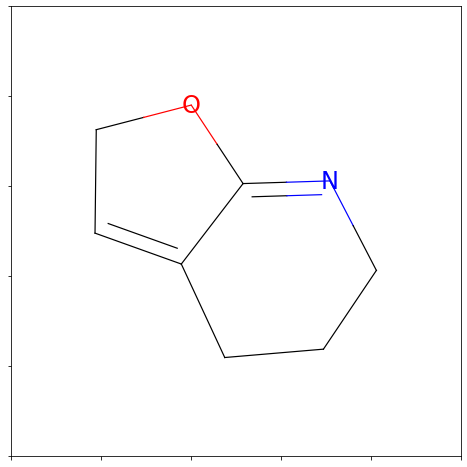

In [19]:
from rdkit.Chem.Draw import SimilarityMaps
import matplotlib

for j in range(7, 62):
    mol = mols[j]
    AllChem.ComputeGasteigerCharges(mol)
    contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap=None,  contourLines=10)

In [ ]:
def reward(self, mols):
    rr = 1.
    for m in ('logp,sas,qed,unique' if self.metric == 'all' else self.metric).split(','):

        if m == 'np':
            rr *= MolecularMetrics.natural_product_scores(mols, norm=True)
        elif m == 'logp':
            rr *= MolecularMetrics.water_octanol_partition_coefficient_scores(mols, norm=True)
        elif m == 'sas':
            rr *= MolecularMetrics.synthetic_accessibility_score_scores(mols, norm=True)
        elif m == 'qed':
            rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores(mols, norm=True)
        elif m == 'novelty':
            rr *= MolecularMetrics.novel_scores(mols, data)
        elif m == 'dc':
            rr *= MolecularMetrics.drugcandidate_scores(mols, data)
        elif m == 'unique':
            rr *= MolecularMetrics.unique_scores(mols)
        elif m == 'diversity':
            rr *= MolecularMetrics.diversity_scores(mols, data)
        elif m == 'validity':
            rr *= MolecularMetrics.valid_scores(mols)
        else:
            raise RuntimeError('{} is not defined as a metric'.format(m))

    return rr.reshape(-1, 1)

In [ ]:
np.mean([i for i in MolecularMetrics.natural_product_scores(mols, norm=True) if i != 0 ])

In [47]:
a_fake.shape

torch.Size([128, 9])

In [103]:
from frechetdist import frdist
R=[list(a_real[i].reshape(-1))  for i in range(128)] #list(x_real[i]) +
F=[list(a_real_2[i].reshape(-1))  for i in range(128)] #list(x_fake[i]) + 
frdist(R,F)

12.083045973594572

In [91]:
x_real_2[0]*0.2

array([0.2, 0.2, 0.6, 0.2, 0.6, 0.2, 0.4, 0.2, 0.2])

In [90]:
a_1 = a
a_2 = a_1
a_3 = a_2

In [89]:
a1

array([0.2, 0.2, 0.6, 0.2, 0.6, 0.2, 0.4, 0.2, 0.2])